In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm import tqdm_notebook
from sklearn import preprocessing
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.metrics import mae, mse
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
station_data = pd.read_csv('station_data.csv')
trip_data = pd.read_csv('trip_data.csv')
weather_data = pd.read_csv('weather_data.csv')

station_data['Id'] = station_data['Id'].astype(str)

trip_data['Start Date'] = pd.to_datetime(trip_data['Start Date'])
trip_data['End Date'] = pd.to_datetime(trip_data['End Date'])
trip_data['Start Station'] = trip_data['Start Station'].astype(str)
trip_data['End Station'] = trip_data['End Station'].astype(str)

weather_data['Date'] = pd.to_datetime(weather_data['Date'])
weather_data['Date'] = weather_data['Date'].apply(lambda x : x.date())
weather_data['Events'] = weather_data['Events'].fillna('None')

def zip_to_city(zip_code):
    switcher = {
        94107: 'San Francisco',
        94063: 'Redwood City',
        94301: 'Palo Alto',
        94041: 'Mountain View',
        95113: 'San Jose'
    }
    return switcher.get(zip_code)
weather_data['City'] = list((map(zip_to_city, weather_data['Zip'])))
weather_data = weather_data.drop(['Zip'], axis=1)

# Notes

Stations 23,25,49,69, 72 -> 85,86,87,88,89 -> 90

Net rate = trips ended - trips started (for a given hour)

In [3]:
station_data.head()

,Id,Name,Lat,Long,Dock Count,City
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose


In [4]:
trip_data.head()

,Trip ID,Start Date,Start Station,End Date,End Station,Subscriber Type
0,913460,2015-08-31 23:26:00,50,2015-08-31 23:39:00,70,Subscriber
1,913459,2015-08-31 23:11:00,31,2015-08-31 23:28:00,27,Subscriber
2,913455,2015-08-31 23:13:00,47,2015-08-31 23:18:00,64,Subscriber
3,913454,2015-08-31 23:10:00,10,2015-08-31 23:17:00,8,Subscriber
4,913453,2015-08-31 23:09:00,51,2015-08-31 23:22:00,60,Customer


In [5]:
weather_data.head()

,Date,Max TemperatureF,Mean TemperatureF,Min TemperatureF,Max Dew PointF,MeanDew PointF,Min DewpointF,Max Humidity,Mean Humidity,Min Humidity,...,Mean VisibilityMiles,Min VisibilityMiles,Max Wind SpeedMPH,Mean Wind SpeedMPH,Max Gust SpeedMPH,PrecipitationIn,CloudCover,Events,WindDirDegrees,City
0,2014-01-09,83.0,70.0,57.0,58.0,56.0,52.0,86.0,64.0,42.0,...,10.0,8.0,16.0,7.0,20.0,0.0,0.0,None,290.0,San Francisco
1,2014-02-09,72.0,66.0,60.0,58.0,57.0,55.0,84.0,73.0,61.0,...,10.0,7.0,21.0,8.0,NaN,0.0,5.0,None,290.0,San Francisco
2,2014-03-09,76.0,69.0,61.0,57.0,56.0,55.0,84.0,69.0,53.0,...,10.0,10.0,21.0,8.0,24.0,0.0,4.0,None,276.0,San Francisco
3,2014-04-09,74.0,68.0,61.0,57.0,57.0,56.0,84.0,71.0,57.0,...,10.0,8.0,22.0,8.0,25.0,0.0,5.0,None,301.0,San Francisco
4,2014-05-09,72.0,66.0,60.0,57.0,56.0,54.0,84.0,71.0,57.0,...,9.0,7.0,18.0,8.0,32.0,0.0,4.0,None,309.0,San Francisco


In [6]:
weather_data['Events'].unique()

array(['None', 'Rain', 'Fog', 'Fog-Rain', 'Rain-Thunderstorm'],
      dtype=object)

# Step 1: Problem analysis

What do we want to achieve?

What models/algorithms are likely to be applicable?

Initial feeling of avenues to pursue?

## Objectives

Predict the net rate per given hour - assume "clock hr of the day" (24 hr-windows)

Therefore, a regression problem -> predict a continuous value

## Data

Station info, trip data, daily weather

Station ID is important factor. Most of rest of trip data fields will merely serve to generate labelled data.

Station info can influence rate by geolocation, affluency/culture, dock count

Daily weather measurements can have influence on whether people are eager to cycle

## Potential models

### Accuracy

Random Forest, Neural Network, Gradient Boosting Tree

### Speed

Decision Tree, Linear Regression


# Step 2: Make some labelled data

Actual net rate per hour

Assume "per clock hour of each day"

In [7]:
trip_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354152 entries, 0 to 354151
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Trip ID          354152 non-null  int64         
 1   Start Date       354152 non-null  datetime64[ns]
 2   Start Station    354152 non-null  object        
 3   End Date         354152 non-null  datetime64[ns]
 4   End Station      354152 non-null  object        
 5   Subscriber Type  354152 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 16.2+ MB


In [8]:
end_indexed = trip_data.set_index('End Date')
#display(end_indexed)
grouper = end_indexed.groupby([pd.Grouper(freq='1H'), 'End Station'])
end_result = grouper['Trip ID'].count().unstack('End Station').fillna(0)
#display(end_result)
#end_result.plot(figsize=(20,10))

In [9]:
start_indexed = trip_data.set_index('Start Date')
#display(end_indexed)
grouper = start_indexed.groupby([pd.Grouper(freq='1H'), 'Start Station'])
start_result = grouper['Trip ID'].count().unstack('Start Station').fillna(0)
#display(start_result)
#start_result.plot(figsize=(20,10))

Station ID,10,11,12,13,14,16,2,21,22,23,...,82,83,84,85,86,87,88,89,9,90
Datetime,,,,,,,,,,,,,,,,,,,,,
2014-01-09 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-09 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-09 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-09 05:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-09 06:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-08 19:00:00,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,-1.0,0.0,0.0,0.0,0.0,-1.0,-5.0,0.0,1.0,0.0
2015-12-08 20:00:00,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,-1.0,5.0,0.0,1.0,0.0
2015-12-08 21:00:00,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0


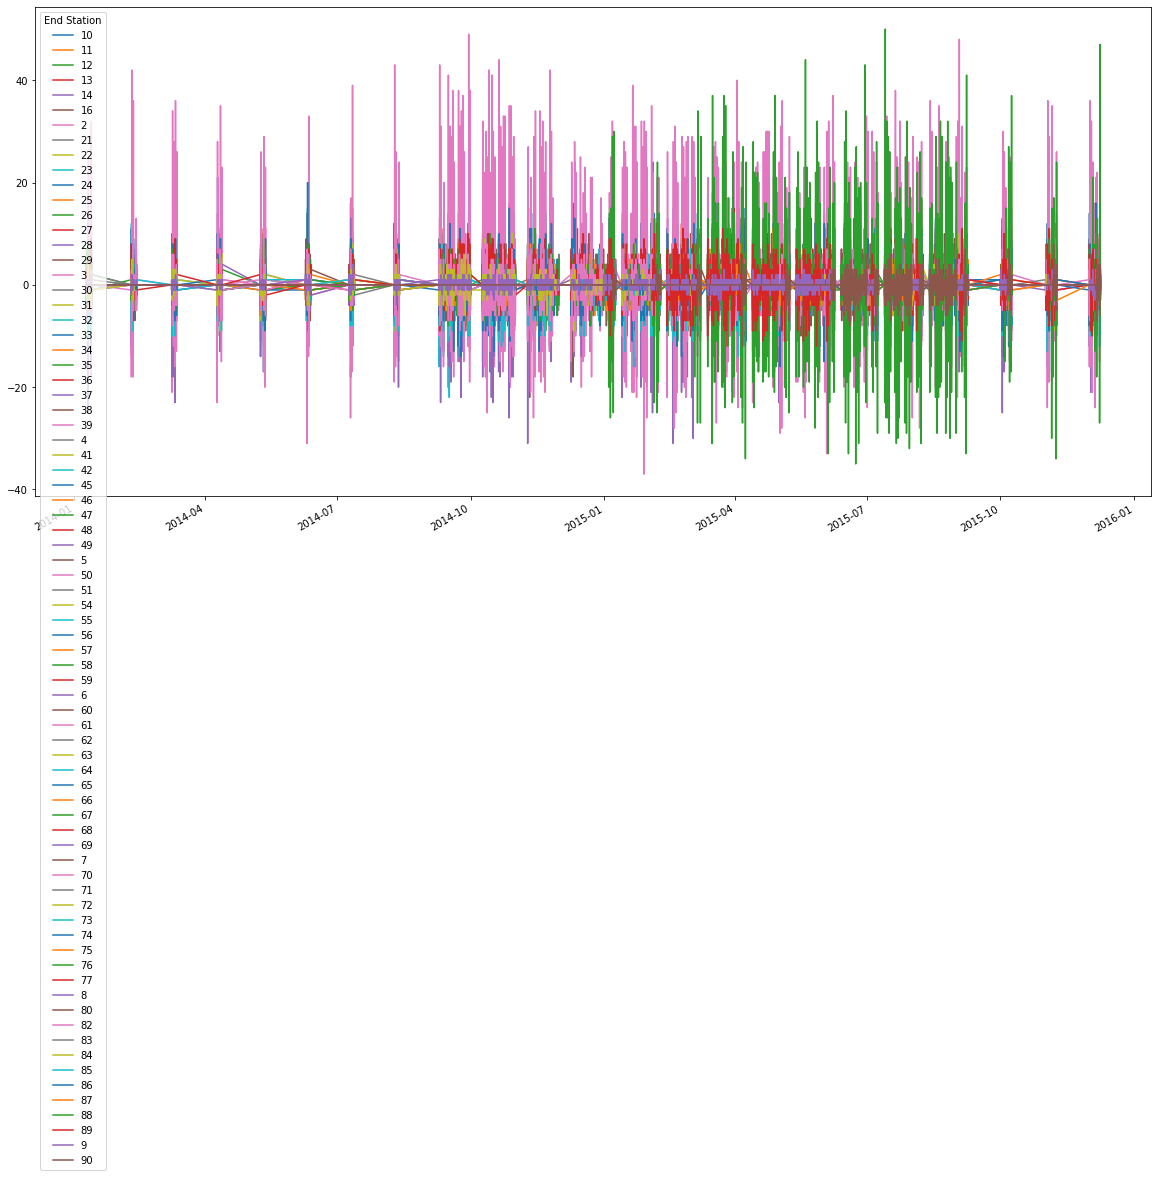

In [10]:
net_rates_by_station = end_result - start_result
net_rates_by_station.fillna(0, inplace=True)
net_rates_by_station.plot(figsize=(20,10))
net_rates_by_station.index.name = 'Datetime'
net_rates_by_station.columns.name = 'Station ID'
display(net_rates_by_station)

In [11]:
def check_station_id(station_ID):
    return station_ID in station_data['Id'].unique()

def get_net_rate(datetime, station_ID):
    if check_station_id(station_ID):
        return [net_rates_by_station.loc[datetime][station_ID]]
    else: print('Station ID doesn\'t exist: %d' % station_ID)

def get_weather(datetime, station_ID):
    if check_station_id(station_ID):
        station_city = station_data[station_data['Id'] == station_ID].iloc[0]['City']
        df = weather_data[(weather_data['Date'] == datetime.date()) & (weather_data['City'] == station_city)].drop(['Date'], axis=1)
        return df.values.tolist()[0]
    else: print('Station ID doesn\'t exist: %d' % station_ID)
        
def get_station(station_ID):
    if check_station_id(station_ID):
        df = station_data[station_data['Id'] == station_ID].drop(['Name','City'], axis=1)
        return df.values.tolist()[0]
    else: print('Station ID doesn\'t exist: %d' % station_ID)
        
# https://stats.stackexchange.com/questions/311494/best-practice-for-encoding-datetime-in-machine-learning
# https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
def get_cyclic_datetime(datetime):
    days_in_month = datetime.days_in_month
    days_in_year = 366 if datetime.is_leap_year else 365
    
    year = str(datetime.year)
    month_sin = np.sin(2*np.pi*datetime.month/12)
    month_cos = np.cos(2*np.pi*datetime.month/12)
    day_sin = np.sin(2*np.pi*datetime.day/days_in_month)
    day_cos = np.cos(2*np.pi*datetime.day/days_in_month)
    day_of_week_sin = np.sin(2*np.pi*datetime.dayofweek/7)
    day_of_week_cos = np.cos(2*np.pi*datetime.dayofweek/7)
    day_of_year_sin = np.sin(2*np.pi*datetime.dayofyear/days_in_year)
    day_of_year_cos = np.cos(2*np.pi*datetime.dayofyear/days_in_year)
    hour_sin = np.sin(2*np.pi*datetime.hour/24)
    hour_cos = np.cos(2*np.pi*datetime.hour/24)
    return [
        year, 
        month_sin, 
        month_cos, 
        day_sin, 
        day_cos, 
        day_of_week_sin,
        day_of_week_cos,
        day_of_year_sin, 
        day_of_year_cos,
        hour_sin,
        hour_cos
    ]

def get_dataset_columns():
    station_cols = list(station_data.drop(['Name','City'], axis=1).columns.values)
    net_rate_cols = ['Net Rate']
    time_cols = [
        'Year', 
        'Month (sine)',
        'Month (cosine)',
        'Day (sine)',
        'Day (cosine)',
        'Day of Week (sine)',
        'Day of Week (cosine)',
        'Day of Year (sine)',
        'Day of Year (cosine)',
        'Hour (sine)',
        'Hour (cosine)',
    ]
    weather_cols = list(weather_data.drop(['Date'], axis=1).columns.values)
    return station_cols + net_rate_cols + time_cols + weather_cols

def gen_dataset_row(datetime, station_ID):
    station = get_station(station_ID)
    net_rate = get_net_rate(datetime, station_ID)
    time = get_cyclic_datetime(datetime)
    weather = get_weather(datetime, station_ID)
    
    return station + net_rate + time + weather

def gen_dataset():
    time_range = net_rates_by_station.index.tolist()
    station_IDs = station_data['Id'].unique()
    rows = []
    for station_ID in tqdm_notebook(station_IDs, desc='Station IDs'):
        for datetime in tqdm_notebook(time_range, desc='Hour intervals'):
            rows.append(gen_dataset_row(datetime, station_ID))
    return pd.DataFrame(rows, columns=get_dataset_columns())
        
    
#test_date = pd.to_datetime('2015-12-08 22:00:00')
#test_station = '2'
#display(gen_dataset_row(test_date, test_station))

In [12]:
#dataset = gen_dataset()
#display(dataset)

In [13]:
#dataset.to_csv('./input_dataset.csv')

In [14]:
dataset = pd.read_csv('input_dataset.csv')

In [15]:
dataset = dataset.dropna(axis=0)
# remove minute drop, not needed
dataset = dataset.drop([ 'Unnamed: 0', 'Id', 'City', 'Events', 'Minute (sine)', 'Minute (cosine)'], axis=1)
#dataset['Id'] = dataset['Id'].astype(str)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 527939 entries, 0 to 613547
Data columns (total 36 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Lat                        527939 non-null  float64
 1   Long                       527939 non-null  float64
 2   Dock Count                 527939 non-null  int64  
 3   Net Rate                   527939 non-null  float64
 4   Year                       527939 non-null  int64  
 5   Month (sine)               527939 non-null  float64
 6   Month (cosine)             527939 non-null  float64
 7   Day (sine)                 527939 non-null  float64
 8   Day (cosine)               527939 non-null  float64
 9   Day of Week (sine)         527939 non-null  float64
 10  Day of Week (cosine)       527939 non-null  float64
 11  Day of Year (sine)         527939 non-null  float64
 12  Day of Year (cosine)       527939 non-null  float64
 13  Hour (sine)                52

In [16]:
dataset.describe()

,Lat,Long,Dock Count,Net Rate,Year,Month (sine),Month (cosine),Day (sine),Day (cosine),Day of Week (sine),...,Min Sea Level PressureIn,Max VisibilityMiles,Mean VisibilityMiles,Min VisibilityMiles,Max Wind SpeedMPH,Mean Wind SpeedMPH,Max Gust SpeedMPH,PrecipitationIn,CloudCover,WindDirDegrees
count,527939.000000,527939.000000,527939.000000,527939.000000,527939.000000,5.279390e+05,5.279390e+05,5.279390e+05,527939.000000,527939.000000,...,527939.000000,527939.000000,527939.000000,527939.000000,527939.000000,527939.000000,527939.000000,527939.000000,527939.000000,527939.000000
mean,37.616802,-122.233588,18.133354,-0.000078,2014.665638,-1.627381e-02,-9.088526e-03,-7.418390e-03,-0.006421,0.002545,...,29.956463,10.017979,9.482147,7.759277,17.489663,6.994335,22.175090,0.036833,3.710783,254.760986
std,0.205953,0.216950,3.912374,1.760382,0.471768,7.094254e-01,7.045354e-01,7.112498e-01,0.702872,0.708699,...,0.128297,0.566424,1.158870,3.003728,5.656747,3.245935,6.429518,0.215828,2.276654,77.898414
min,37.329732,-122.418954,11.000000,-37.000000,2014.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000,-0.974928,...,29.520000,6.000000,4.000000,0.000000,6.000000,1.000000,7.000000,0.000000,0.000000,0.000000
25%,37.385956,-122.402717,15.000000,0.000000,2014.000000,-8.660254e-01,-8.660254e-01,-7.247928e-01,-0.758758,-0.781831,...,29.860000,10.000000,10.000000,6.000000,14.000000,5.000000,18.000000,0.000000,2.000000,244.000000
50%,37.776619,-122.392738,19.000000,0.000000,2015.000000,-2.449294e-16,-1.836970e-16,-2.449294e-16,-0.050649,0.000000,...,29.940000,10.000000,10.000000,10.000000,17.000000,7.000000,22.000000,0.000000,4.000000,279.000000
75%,37.789625,-122.066553,19.000000,0.000000,2015.000000,5.000000e-01,5.000000e-01,7.247928e-01,0.688967,0.781831,...,30.040000,10.000000,10.000000,10.000000,21.000000,9.000000,25.000000,0.000000,6.000000,302.000000
max,37.804770,-121.877349,27.000000,50.000000,2015.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,0.974928,...,30.350000,20.000000,18.000000,10.000000,120.000000,23.000000,62.000000,3.360000,8.000000,360.000000


In [17]:
len(dataset[dataset['Net Rate'] == 0])

362315

In [18]:
#cols = dataset.drop(['Net Rate'], axis=1).columns

#sns.pairplot(
#    data=dataset,
#    x_vars='Net Rate',
#    y_vars=cols,
#    kind='reg'
#)

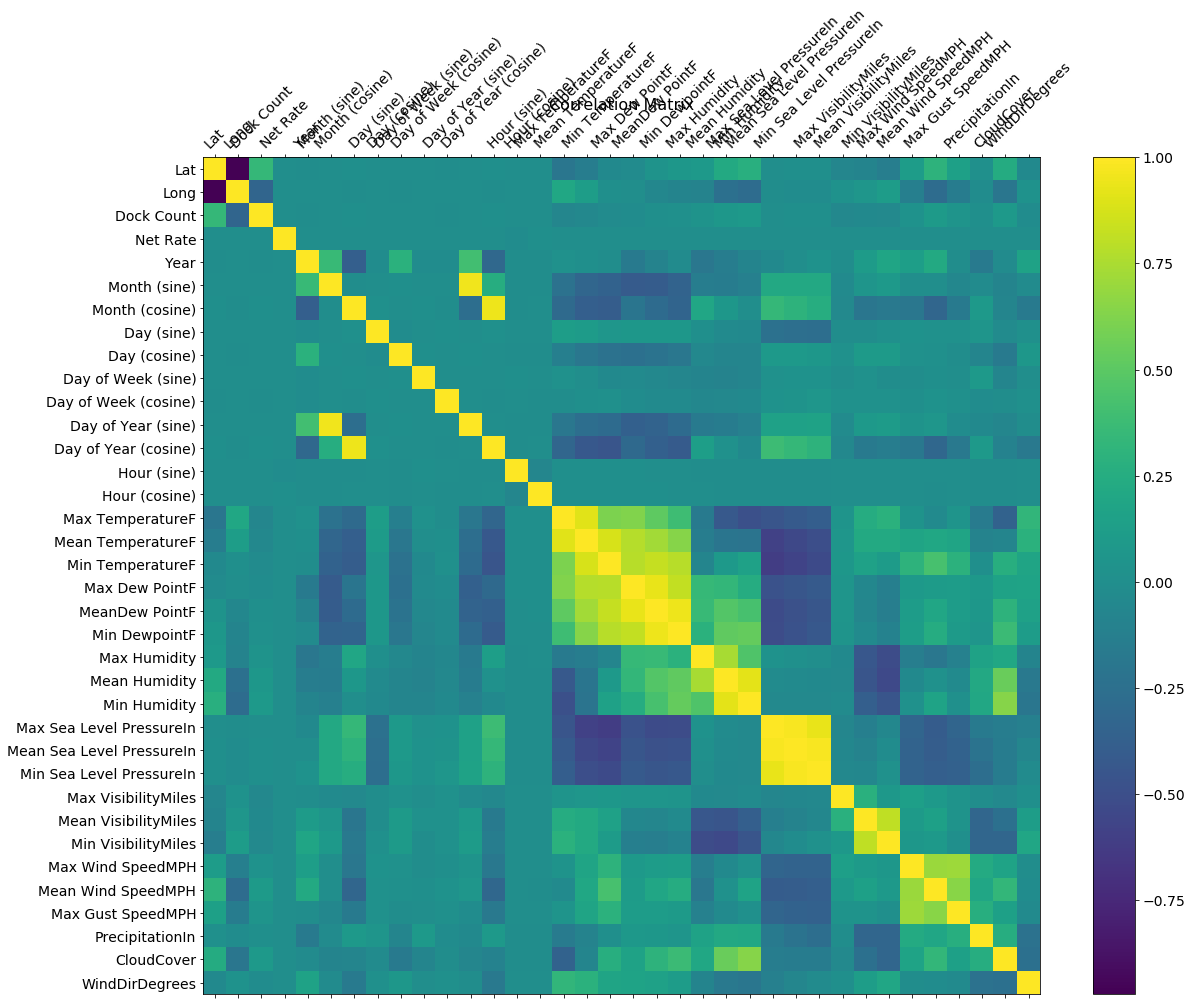

In [19]:
#x = dataset.values #returns a numpy array
#min_max_scaler = preprocessing.MinMaxScaler()
#x_scaled = min_max_scaler.fit_transform(x)
#dataset_scaled = pd.DataFrame(x_scaled)

f = plt.figure(figsize=(19, 15))
plt.matshow(dataset.corr(), fignum=f.number)
plt.xticks(range(dataset.shape[1]), dataset.columns, fontsize=14, rotation=45)
plt.yticks(range(dataset.shape[1]), dataset.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [20]:
#X = dataset.drop(['Net Rate'], axis=1)
#y = dataset['Net Rate']
#X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, test_size=0.2, random_state = 42)

In [21]:
#rf = RandomForestRegressor(
#    n_estimators = 100,
#    bootstrap = True,
#    oob_score = True,
#    random_state = 42
#)

#rf.fit(X_train, y_train)

#print(
#    'R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(
#        rf.score(X_train, y_train), 
#        rf.oob_score_,
#        rf.score(X_test, y_test)
#    )
#)

In [22]:
#print(rf.feature_importances_)
#f_imps = pd.DataFrame([rf.feature_importances_], columns=X.columns)
#f_imps.plot.bar(figsize=(20,10))

In [23]:
X = dataset[['Lat', 'Long', 'Day (sine)', 'Day (cosine)', 'Day of Week (sine)', 'Day of Week (cosine)', 'Day of Year (sine)', 'Day of Year (cosine)', 'Hour (sine)', 'Hour (cosine)']]
y = dataset['Net Rate']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, test_size=0.2, random_state = 42)

In [24]:
#rf = RandomForestRegressor(
#    n_estimators = 100,
#    bootstrap = True,
#    oob_score = True,
#    random_state = 42
#)

#rf.fit(X_train, y_train)

#pickle.dump(rf, open('rf_model_0.5_0.2_100.sav', 'wb'))

In [25]:
rf = pickle.load(open('rf_model_0.5_0.2_100.sav', 'rb'))

In [26]:
print(
    'R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(
        rf.score(X_train, y_train), 
        rf.oob_score_,
        rf.score(X_test, y_test)
    )
)

R^2 Training Score: 0.92 
OOB Score: 0.39 
R^2 Validation Score: 0.39


[0.07230669 0.09282816 0.12043204 0.07969552 0.08913658 0.03159996
 0.12234863 0.11975544 0.12652472 0.14537225]


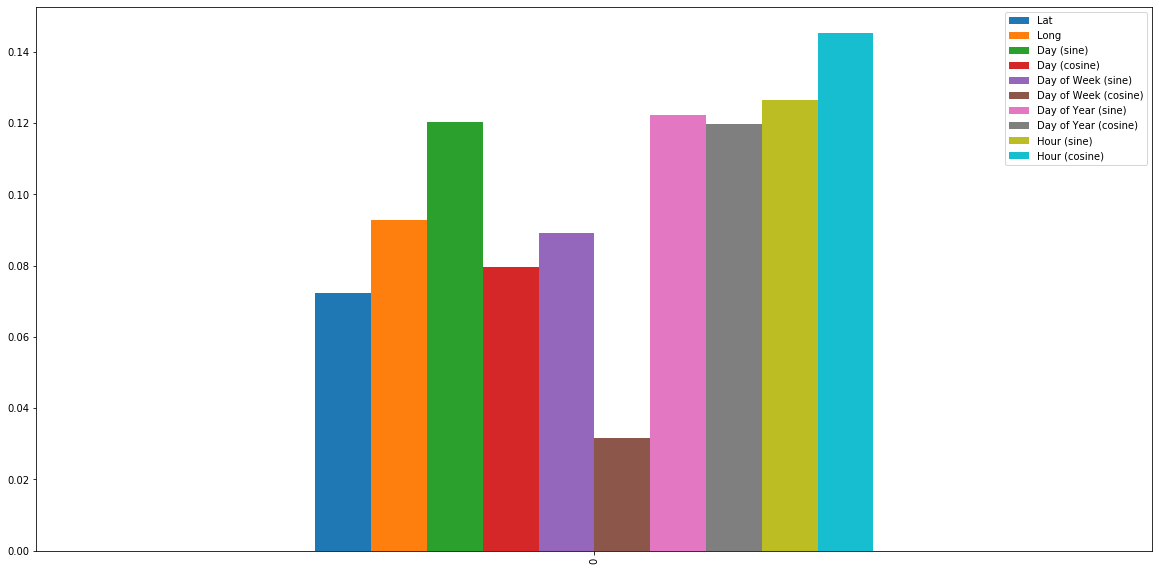

In [27]:
print(rf.feature_importances_)
f_imps = pd.DataFrame([rf.feature_importances_], columns=X.columns)
f_imps.plot.bar(figsize=(20,10))

In [28]:
#X = dataset.drop(['Net Rate'], axis=1)
#y = dataset['Net Rate']
#X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, test_size=0.2, random_state = 42)

# Normalise
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA
#pca = PCA(.95)
#pca.fit(X_train_scaled)
#X_train_pca = pca.transform(X_train_scaled)
#X_test_pca = pca.transform(X_test_scaled)

# RF
rf_1 = RandomForestRegressor(
    n_estimators = 100,
    bootstrap = True,
    oob_score = True,
    random_state = 42,
    n_jobs=4
)

rf_1.fit(X_train_scaled, y_train)

print(
    'R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(
        rf_1.score(X_train_scaled, y_train), 
        rf_1.oob_score_,
        rf_1.score(X_test_scaled, y_test)
    )
)

R^2 Training Score: 0.92 
OOB Score: 0.39 
R^2 Validation Score: 0.39


 0.0     362315
-1.0      47465
 1.0      45267
-2.0      18268
 2.0      17550
          ...  
 47.0         1
 40.0         1
-37.0         1
 49.0         1
 50.0         1
Name: Net Rate, Length: 85, dtype: int64

(527939, 36)
(605, 36)
(2455, 36)


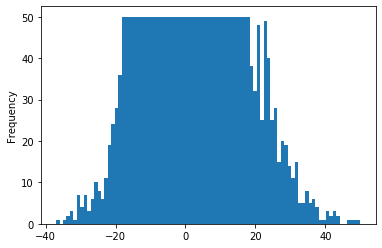

In [3]:
# Let's try balance the data - too many occurences of Net Rate = 0 !!
dataset = pd.read_csv('input_dataset.csv')
dataset = dataset.dropna(axis=0)
dataset = dataset.drop([ 'Unnamed: 0', 'Id', 'City', 'Events', 'Minute (sine)', 'Minute (cosine)'], axis=1)

display(dataset['Net Rate'].value_counts())
over_rep_values = list(range(-18,19))
sample_amount = 50
under_sample_dfs = []
for i in over_rep_values:
    under_sample_dfs.append(dataset[dataset['Net Rate'] == i].sample(sample_amount, replace=True))
    
combined = [dataset[~dataset['Net Rate'].isin(over_rep_values)]]
print(dataset.shape)
print(combined[0].shape)

combined = combined + (under_sample_dfs)

balanced_dataset = pd.concat(combined, axis=0)

print(balanced_dataset.shape)

balanced_dataset['Net Rate'].plot.hist(bins=88)

#zeros = dataset[dataset['Net Rate'] == 0]
#non_zeros = dataset[dataset['Net Rate'] != 0]
#print('zeros' + str(len(zeros)))
#display(non_zeros)
#non_zeros['Net Rate'].plot.hist()

#X = dataset.drop(['Net Rate'], axis=1)
#y = dataset['Net Rate']



In [30]:
balanced_dataset.describe()

,Lat,Long,Dock Count,Net Rate,Year,Month (sine),Month (cosine),Day (sine),Day (cosine),Day of Week (sine),...,Min Sea Level PressureIn,Max VisibilityMiles,Mean VisibilityMiles,Min VisibilityMiles,Max Wind SpeedMPH,Mean Wind SpeedMPH,Max Gust SpeedMPH,PrecipitationIn,CloudCover,WindDirDegrees
count,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2.455000e+03,2.455000e+03,2.455000e+03,2455.000000,2455.000000,...,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000
mean,37.766124,-122.381082,20.107128,2.811813,2014.685540,-4.621154e-02,-8.232283e-02,-6.906457e-03,-0.020054,0.198626,...,29.955849,9.982077,9.476171,7.613849,17.942974,7.755601,22.465988,0.017584,4.046029,258.749491
std,0.082210,0.082577,3.352846,15.440860,0.464395,7.357744e-01,6.709153e-01,7.089175e-01,0.705261,0.631446,...,0.119262,0.351508,1.129070,2.878547,4.820579,3.285105,6.327741,0.103398,2.199300,63.160424
min,37.329732,-122.418954,11.000000,-37.000000,2014.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000,-0.974928,...,29.680000,6.000000,4.000000,0.000000,7.000000,1.000000,8.000000,0.000000,0.000000,4.000000
25%,37.776600,-122.398108,19.000000,-10.000000,2014.000000,-8.660254e-01,-8.660254e-01,-7.247928e-01,-0.713944,-0.433884,...,29.860000,10.000000,9.000000,6.000000,15.000000,5.000000,18.000000,0.000000,2.000000,251.000000
50%,37.776617,-122.395260,19.000000,3.000000,2015.000000,-2.449294e-16,-1.836970e-16,-2.449294e-16,-0.050649,0.433884,...,29.940000,10.000000,10.000000,9.000000,18.000000,8.000000,23.000000,0.000000,4.000000,272.000000
75%,37.789756,-122.395260,23.000000,15.000000,2015.000000,5.000000e-01,5.000000e-01,7.247928e-01,0.688967,0.781831,...,30.020000,10.000000,10.000000,10.000000,21.000000,10.000000,25.000000,0.000000,6.000000,295.000000
max,37.804770,-121.877349,27.000000,50.000000,2015.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,0.974928,...,30.350000,20.000000,13.000000,10.000000,38.000000,22.000000,62.000000,1.430000,8.000000,359.000000


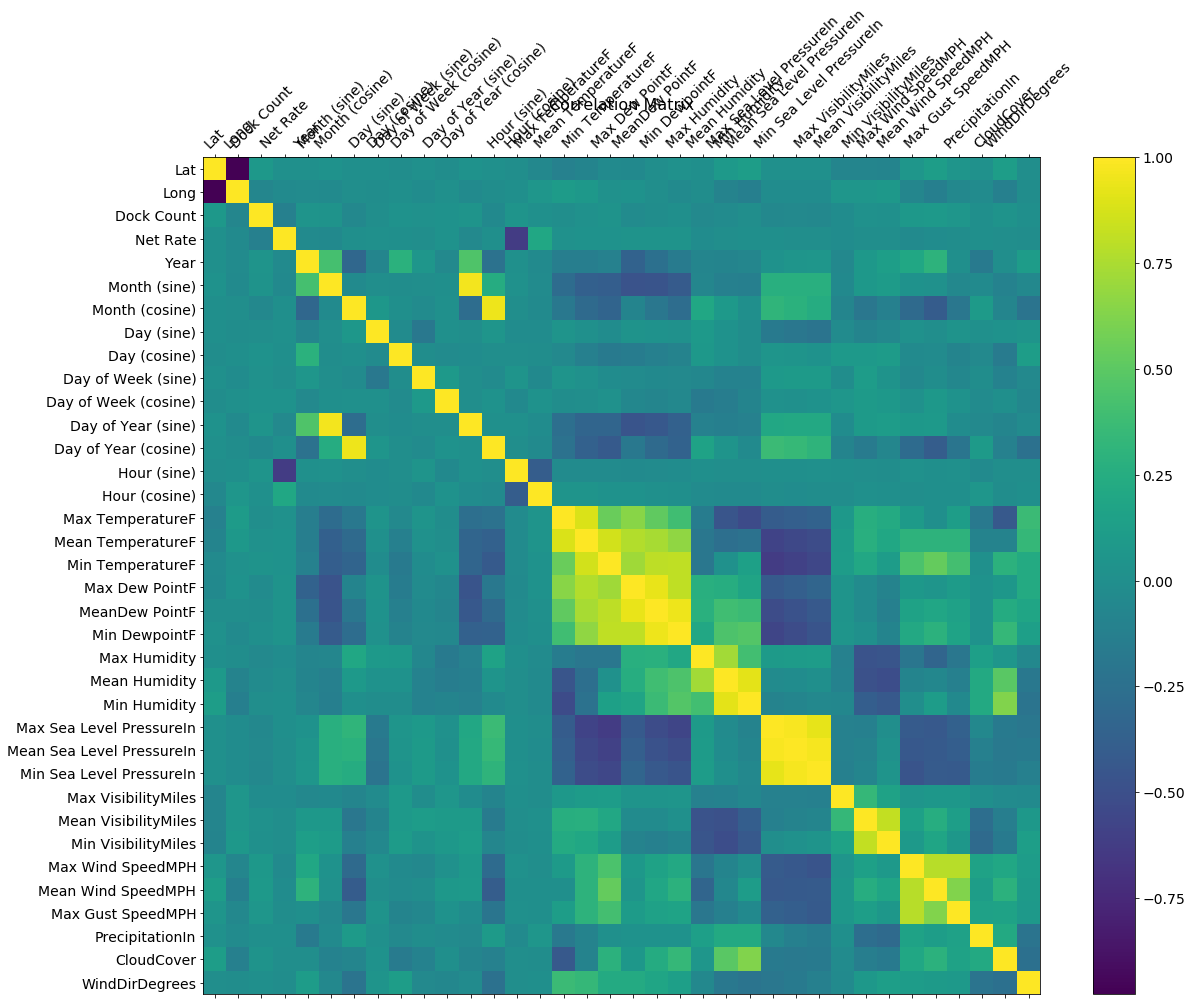

In [31]:
f = plt.figure(figsize=(19, 15))
plt.matshow(balanced_dataset.corr(), fignum=f.number)
plt.xticks(range(dataset.shape[1]), dataset.columns, fontsize=14, rotation=45)
plt.yticks(range(dataset.shape[1]), dataset.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [32]:
X = balanced_dataset.drop(['Net Rate'], axis=1)
y = balanced_dataset['Net Rate']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

rf = RandomForestRegressor(
    n_estimators = 100,
    bootstrap = True,
    oob_score = True,
    random_state = 42,
    n_jobs=4
)

rf.fit(X_train, y_train)

print(
    'R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(
        rf.score(X_train, y_train), 
        rf.oob_score_,
        rf.score(X_test, y_test)
    )
)

R^2 Training Score: 0.99 
OOB Score: 0.89 
R^2 Validation Score: 0.90


In [33]:
y_pred = rf.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 3.6724429967426713
Mean Squared Error: 25.123210423452765
Root Mean Squared Error: 5.0123058988306735


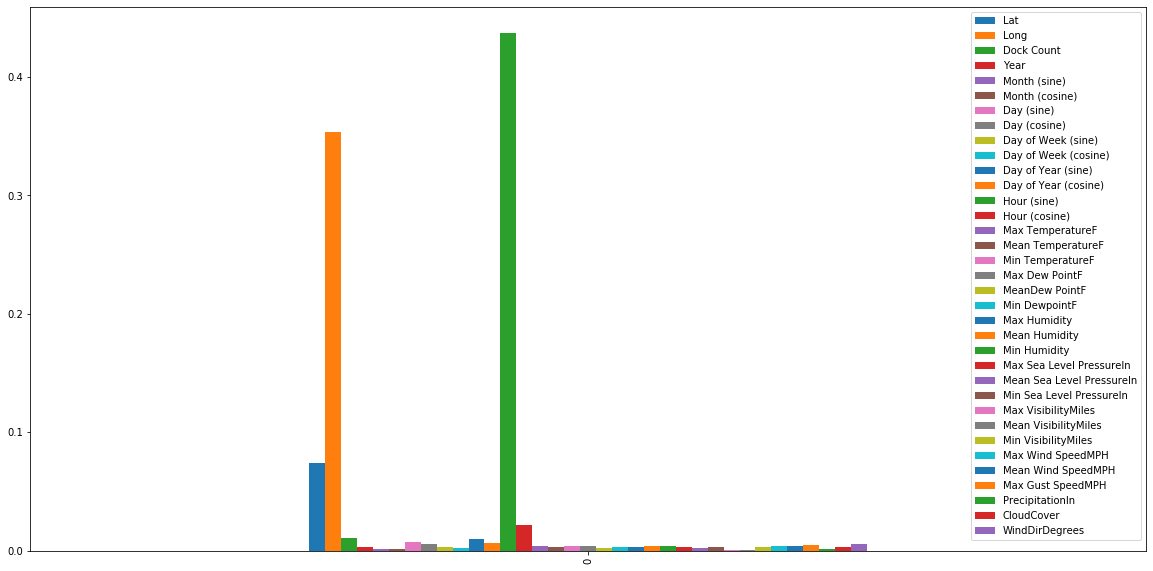

In [34]:
#print(rf.feature_importances_)
f_imps = pd.DataFrame([rf.feature_importances_], columns=X.columns)
f_imps.plot.bar(figsize=(20,10))

In [35]:
#Let's try take the top 4 features?

X = balanced_dataset[['Lat', 'Long', 'Hour (sine)', 'Hour (cosine)']]
y = balanced_dataset['Net Rate']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

rf_2 = RandomForestRegressor(
    n_estimators = 100,
    bootstrap = True,
    oob_score = True,
    random_state = 42,
    n_jobs=4
)

rf_2.fit(X_train, y_train)

print(
    'R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(
        rf_2.score(X_train, y_train), 
        rf_2.oob_score_,
        rf_2.score(X_test, y_test)
    )
)

R^2 Training Score: 0.91 
OOB Score: 0.89 
R^2 Validation Score: 0.89


In [36]:
y_pred = rf_2.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 3.7940204514109865
Mean Squared Error: 26.47229321709011
Root Mean Squared Error: 5.145123246054473


In [54]:
# Put in context of std dev range of Net Rate
relative_accuracy = 100 - (5.145123246054473 / (2*np.std(balanced_dataset['Net Rate'])) *100)
print(relative_accuracy)

83.33586505796828


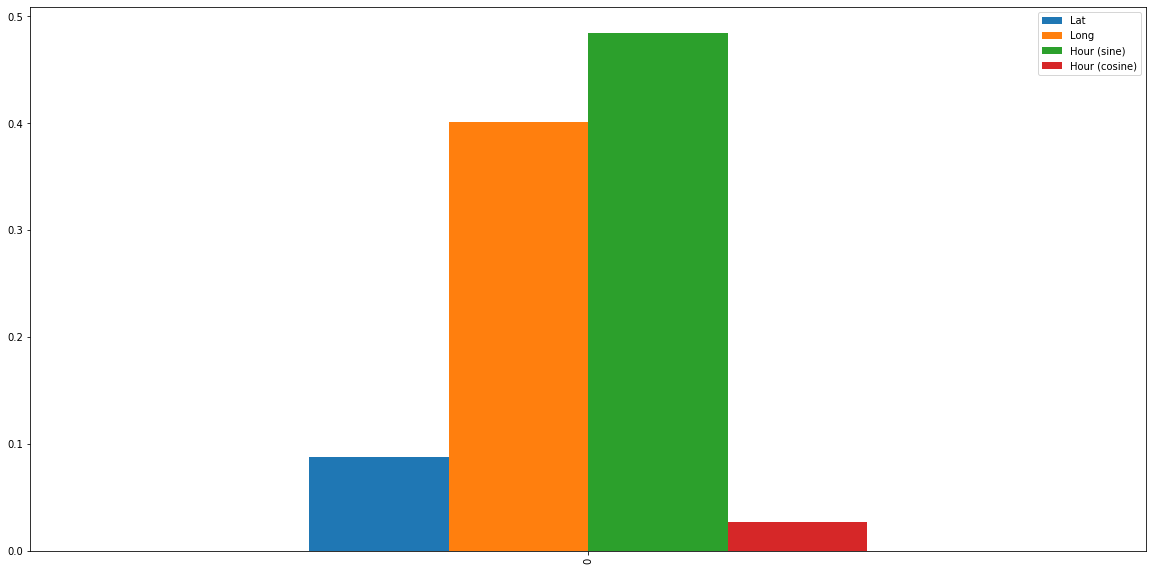

In [37]:
f_imps = pd.DataFrame([rf_2.feature_importances_], columns=X.columns)
f_imps.plot.bar(figsize=(20,10))

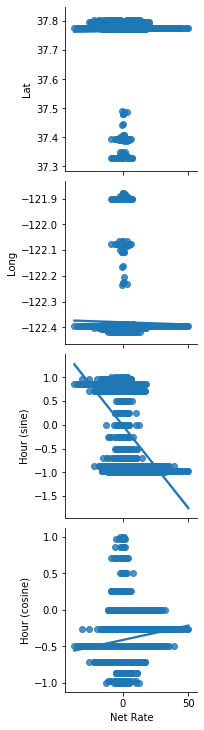

In [38]:
sns.pairplot(
    data=balanced_dataset,
    x_vars='Net Rate',
    y_vars=['Lat', 'Long', 'Hour (sine)', 'Hour (cosine)'],
    kind='reg'
)

In [39]:
# to be silly, let's try the model on random samples of all the data
num_tests = 1000
sample_size = 10000

#print('#\tR^2\tMAE\tMSE\tRMSE')

r2 = []
mae = []
mse = []
rmse = []

for i in tqdm_notebook(range(num_tests)):
    sample = dataset.sample(sample_size, replace=True)
    #display(sample)
    X = sample[['Lat', 'Long', 'Hour (sine)', 'Hour (cosine)']]
    #display(X)
    y = sample['Net Rate']
    #display(y)
    y_pred = rf_2.predict(X)
    #display(y_pred)
    
    r2_score = rf_2.score(X, y)
    mae_score = metrics.mean_absolute_error(y, y_pred)
    mse_score = metrics.mean_squared_error(y, y_pred)
    rmse_score = np.sqrt(metrics.mean_squared_error(y, y_pred))
    
    r2.append(r2_score)
    mae.append(mae_score)
    mse.append(mse_score)
    rmse.append(rmse_score)
    
    #print('%d\t%d\t%d\t%d\t%d' % (i,r2_score, mae_score, mse_score, rmse_score))
    
print('#\tR^2\tMAE\tMSE\tRMSE')

print('%s\t%f\t%f\t%f\t%f' % ('mean',np.mean(r2), np.mean(mae), np.mean(mse), np.mean(rmse)))
print('%s\t%f\t%f\t%f\t%f' % ('std',np.std(r2), np.std(mae), np.std(mse), np.std(rmse)))

/home/tristan/.local/share/virtualenvs/codility-ml-test-tR3UURAZ/lib/python3.6/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':



#	R^2	MAE	MSE	RMSE
mean	-2.518334	2.064057	10.788337	3.284165
std	0.316141	0.026245	0.334447	0.050946


In [40]:
# It definitely doesn't like the PCA linearity

X = balanced_dataset.drop(['Net Rate'], axis=1)
y = balanced_dataset['Net Rate']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

# Normalise
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA
pca = PCA(.95)
pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(X_train_pca.shape)

rf_3 = RandomForestRegressor(
    n_estimators = 100,
    bootstrap = True,
    oob_score = True,
    random_state = 42,
    n_jobs=4
)

rf_3.fit(X_train_pca, y_train)

print(
    'R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(
        rf_3.score(X_train_pca, y_train), 
        rf_3.oob_score_,
        rf_3.score(X_test_pca, y_test)
    )
)

y_pred = rf_3.predict(X_test_pca)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

(1841, 19)
R^2 Training Score: 0.94 
OOB Score: 0.56 
R^2 Validation Score: 0.55
Mean Absolute Error: 7.797573289902282
Mean Squared Error: 107.64909853420195
Root Mean Squared Error: 10.37540835505774


In [41]:
# baseline NN

X = balanced_dataset[['Lat', 'Long', 'Hour (sine)', 'Hour (cosine)']]
y = balanced_dataset['Net Rate']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

# Normalise
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

def baseline_nn():
    #create
    model = Sequential()
    model.add(Dense(4, input_dim=4, kernel_initializer='normal', activation='relu')) # input
    model.add(Dense(1, kernel_initializer='normal')) #output
    #compile
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return model

model = baseline_nn()
model.fit(X_train_scaled, y_train, epochs=50, batch_size=10)

# evaluate the keras model
_, accuracy = model.evaluate(X_test_scaled, y_test)
print('Accuracy: %.2f' % (accuracy*100))

# evaluate
#estimator = KerasRegressor(build_fn=baseline_nn, epochs=100, batch_size=5)
#kfold = KFold(n_splits=10)
#results = cross_val_score(estimator, X, y, cv=kfold)
#print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Epoch 1/50
1841/1841 [==============================] - 0s 101us/step - loss: 242.6546 - accuracy: 0.0196
Epoch 2/50
1841/1841 [==============================] - 0s 63us/step - loss: 231.8551 - accuracy: 0.0212
Epoch 3/50
1841/1841 [==============================] - 0s 60us/step - loss: 215.6871 - accuracy: 0.0174
Epoch 4/50
1841/1841 [==============================] - 0s 62us/step - loss: 200.8894 - accuracy: 0.0163
Epoch 5/50
1841/1841 [==============================] - 0s 60us/step - loss: 190.1601 - accuracy: 0.0163
Epoch 6/50
1841/1841 [==============================] - 0s 61us/step - loss: 183.1848 - accuracy: 0.0244
Epoch 7/50
1841/1841 [==============================] - 0s 62us/step - loss: 178.7788 - accuracy: 0.0239
Epoch 8/50
1841/1841 [==============================] - 0s 61us/step - loss: 176.1689 - accuracy: 0.0244
Epoch 9/50
1841/1841 [==============================] - 0s 64us/step - loss: 174.2982 - accuracy: 0.0239
Epoch 10/50
1841/1841 [==============================]

In [42]:
# deeper NN

X = balanced_dataset[['Lat', 'Long', 'Hour (sine)', 'Hour (cosine)']]
y = balanced_dataset['Net Rate']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

# Normalise
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

def deeper_nn():
    #create
    model = Sequential()
    model.add(Dense(4, input_dim=4, kernel_initializer='normal', activation='relu')) # input
    model.add(Dense(6, kernel_initializer='normal'))
    model.add(Dense(4, kernel_initializer='normal'))
    model.add(Dense(1, kernel_initializer='normal')) #output
    #compile
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return model

model = deeper_nn()
model.fit(X_train_scaled, y_train, epochs=50, batch_size=10)

# evaluate the keras model
_, accuracy = model.evaluate(X_test_scaled, y_test)
print('Accuracy: %.2f' % (accuracy*100))

# evaluate
#estimator = KerasRegressor(build_fn=baseline_nn, epochs=100, batch_size=5)
#kfold = KFold(n_splits=10)
#results = cross_val_score(estimator, X, y, cv=kfold)
#print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Epoch 1/50
1841/1841 [==============================] - 0s 113us/step - loss: 241.5657 - accuracy: 0.0206
Epoch 2/50
1841/1841 [==============================] - 0s 69us/step - loss: 183.2590 - accuracy: 0.0201
Epoch 3/50
1841/1841 [==============================] - 0s 69us/step - loss: 145.9742 - accuracy: 0.0304
Epoch 4/50
1841/1841 [==============================] - 0s 72us/step - loss: 140.8048 - accuracy: 0.0364
Epoch 5/50
1841/1841 [==============================] - 0s 71us/step - loss: 139.1863 - accuracy: 0.0391
Epoch 6/50
1841/1841 [==============================] - 0s 73us/step - loss: 138.6919 - accuracy: 0.0413
Epoch 7/50
1841/1841 [==============================] - 0s 76us/step - loss: 138.0591 - accuracy: 0.0445
Epoch 8/50
1841/1841 [==============================] - 0s 77us/step - loss: 138.1057 - accuracy: 0.0429
Epoch 9/50
1841/1841 [==============================] - 0s 72us/step - loss: 137.6986 - accuracy: 0.0418
Epoch 10/50
1841/1841 [==============================]

In [43]:
# wider NN

from keras.metrics import mae, mse

#X = balanced_dataset[['Lat', 'Long', 'Hour (sine)', 'Hour (cosine)']]
X = balanced_dataset.drop(['Net Rate'], axis=1)
y = balanced_dataset['Net Rate']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

# Normalise
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

def wider_nn():
    #create
    model = Sequential()
    model.add(Dense(20, input_dim=35, kernel_initializer='normal', activation='relu')) # input
    model.add(Dense(20, kernel_initializer='normal'))
    model.add(Dense(20, kernel_initializer='normal'))
    model.add(Dense(1, kernel_initializer='normal')) #output
    #compile
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[mae, mse])
    return model

model = wider_nn()
history = model.fit(X_train_scaled, y_train, epochs=500, batch_size=10)

# evaluate the keras model
_, mae, mse = model.evaluate(X_test_scaled, y_test)
#print('Accuracy: %.2f' % (accuracy*100))

# evaluate
#estimator = KerasRegressor(build_fn=baseline_nn, epochs=100, batch_size=5)
#kfold = KFold(n_splits=10)
#results = cross_val_score(estimator, X, y, cv=kfold)
#print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Epoch 1/500
1841/1841 [==============================] - 0s 143us/step - loss: 217.0002 - mean_absolute_error: 12.3474 - mean_squared_error: 217.0002
Epoch 2/500
1841/1841 [==============================] - 0s 71us/step - loss: 137.3663 - mean_absolute_error: 9.5310 - mean_squared_error: 137.3663
Epoch 3/500
1841/1841 [==============================] - 0s 75us/step - loss: 122.6746 - mean_absolute_error: 8.8312 - mean_squared_error: 122.6745
Epoch 4/500
1841/1841 [==============================] - 0s 90us/step - loss: 116.9566 - mean_absolute_error: 8.5819 - mean_squared_error: 116.9565
Epoch 5/500
1841/1841 [==============================] - 0s 78us/step - loss: 114.6223 - mean_absolute_error: 8.5047 - mean_squared_error: 114.6223
Epoch 6/500
1841/1841 [==============================] - 0s 90us/step - loss: 110.9925 - mean_absolute_error: 8.2864 - mean_squared_error: 110.9925
Epoch 7/500
1841/1841 [==============================] - 0s 74us/step - loss: 109.8134 - mean_absolute_error: 

1841/1841 [==============================] - 0s 69us/step - loss: 63.6871 - mean_absolute_error: 6.1153 - mean_squared_error: 63.6871
Epoch 112/500
1841/1841 [==============================] - 0s 68us/step - loss: 61.2717 - mean_absolute_error: 5.9859 - mean_squared_error: 61.2717
Epoch 113/500
1841/1841 [==============================] - 0s 69us/step - loss: 63.1378 - mean_absolute_error: 6.1287 - mean_squared_error: 63.1378
Epoch 114/500
1841/1841 [==============================] - 0s 70us/step - loss: 61.5751 - mean_absolute_error: 6.0121 - mean_squared_error: 61.5751
Epoch 115/500
1841/1841 [==============================] - 0s 68us/step - loss: 63.3543 - mean_absolute_error: 6.0752 - mean_squared_error: 63.3543
Epoch 116/500
1841/1841 [==============================] - 0s 69us/step - loss: 62.2586 - mean_absolute_error: 6.0708 - mean_squared_error: 62.2586
Epoch 117/500
1841/1841 [==============================] - 0s 70us/step - loss: 60.8181 - mean_absolute_error: 5.9779 - mean_s

1841/1841 [==============================] - 0s 68us/step - loss: 47.2519 - mean_absolute_error: 5.3096 - mean_squared_error: 47.2519
Epoch 222/500
1841/1841 [==============================] - 0s 69us/step - loss: 47.5185 - mean_absolute_error: 5.3362 - mean_squared_error: 47.5185
Epoch 223/500
1841/1841 [==============================] - 0s 69us/step - loss: 48.2181 - mean_absolute_error: 5.3681 - mean_squared_error: 48.2181
Epoch 224/500
1841/1841 [==============================] - 0s 72us/step - loss: 46.2255 - mean_absolute_error: 5.2650 - mean_squared_error: 46.2255
Epoch 225/500
1841/1841 [==============================] - 0s 72us/step - loss: 48.6065 - mean_absolute_error: 5.3629 - mean_squared_error: 48.6065
Epoch 226/500
1841/1841 [==============================] - 0s 72us/step - loss: 46.3793 - mean_absolute_error: 5.2442 - mean_squared_error: 46.3793
Epoch 227/500
1841/1841 [==============================] - 0s 82us/step - loss: 46.8124 - mean_absolute_error: 5.2800 - mean_s

1841/1841 [==============================] - 0s 71us/step - loss: 41.2953 - mean_absolute_error: 4.9778 - mean_squared_error: 41.2953
Epoch 332/500
1841/1841 [==============================] - 0s 69us/step - loss: 42.3098 - mean_absolute_error: 5.0243 - mean_squared_error: 42.3098
Epoch 333/500
1841/1841 [==============================] - 0s 71us/step - loss: 41.5820 - mean_absolute_error: 4.9684 - mean_squared_error: 41.5820
Epoch 334/500
1841/1841 [==============================] - 0s 67us/step - loss: 41.0658 - mean_absolute_error: 4.9649 - mean_squared_error: 41.0658
Epoch 335/500
1841/1841 [==============================] - 0s 70us/step - loss: 42.5015 - mean_absolute_error: 5.1006 - mean_squared_error: 42.5015
Epoch 336/500
1841/1841 [==============================] - 0s 67us/step - loss: 42.0850 - mean_absolute_error: 5.0130 - mean_squared_error: 42.0850
Epoch 337/500
1841/1841 [==============================] - 0s 70us/step - loss: 40.4056 - mean_absolute_error: 4.9124 - mean_s

1841/1841 [==============================] - 0s 71us/step - loss: 40.0129 - mean_absolute_error: 4.8923 - mean_squared_error: 40.0129
Epoch 442/500
1841/1841 [==============================] - 0s 69us/step - loss: 39.3279 - mean_absolute_error: 4.8895 - mean_squared_error: 39.3279
Epoch 443/500
1841/1841 [==============================] - 0s 69us/step - loss: 39.8872 - mean_absolute_error: 4.9033 - mean_squared_error: 39.8872
Epoch 444/500
1841/1841 [==============================] - 0s 72us/step - loss: 38.7495 - mean_absolute_error: 4.8187 - mean_squared_error: 38.7495
Epoch 445/500
1841/1841 [==============================] - 0s 71us/step - loss: 39.2549 - mean_absolute_error: 4.8384 - mean_squared_error: 39.2549
Epoch 446/500
1841/1841 [==============================] - 0s 72us/step - loss: 39.2406 - mean_absolute_error: 4.8133 - mean_squared_error: 39.2406
Epoch 447/500
1841/1841 [==============================] - 0s 73us/step - loss: 40.1358 - mean_absolute_error: 4.9146 - mean_s

In [44]:
print('MAE\t\tRMSE\n%f\t%f' % (mae,np.sqrt(mse)))

MAE		RMSE
6.909476	8.920331


In [45]:
for key in history.history:
    print(key)

loss
mean_absolute_error
mean_squared_error


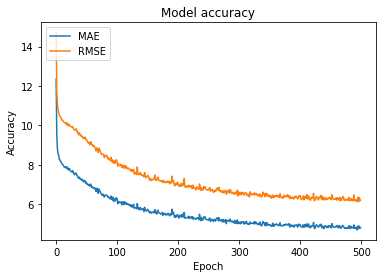

In [46]:
# Plot training & validation accuracy values
#plt.plot(history.history['accuracy'])
plt.plot(history.history['mean_absolute_error'])
plt.plot(np.sqrt(history.history['mean_squared_error']))
#plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['MAE', 'RMSE'], loc='upper left')
plt.show()

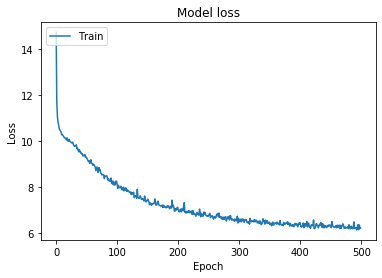

In [47]:
# Plot training & validation loss values
plt.plot(np.sqrt(history.history['loss']))
#plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

(4910, 36)
R^2 Training Score: 0.91 
OOB Score: 0.90 
R^2 Validation Score: 0.91


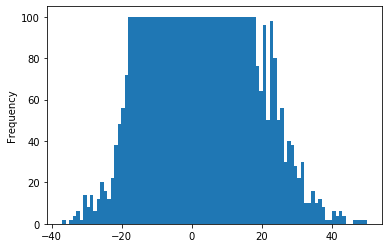

In [14]:
# Let's try duplicate data with top 4 features

duplicated_balanced_dataset = pd.concat([balanced_dataset, balanced_dataset] , axis=0)

print(duplicated_balanced_dataset.shape)

duplicated_balanced_dataset['Net Rate'].plot.hist(bins=88)

X = duplicated_balanced_dataset[['Lat', 'Long', 'Hour (sine)', 'Hour (cosine)']]
y = duplicated_balanced_dataset['Net Rate']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

# Normalise
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_dup = RandomForestRegressor(
    n_estimators = 100,
    bootstrap = True,
    oob_score = True,
    random_state = 42,
    n_jobs=4
)

rf_dup.fit(X_train_scaled, y_train)

print(
    'R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(
        rf_dup.score(X_train_scaled, y_train), 
        rf_dup.oob_score_,
        rf_dup.score(X_test_scaled, y_test)
    )
)

In [19]:
y_pred = rf_dup.predict(X_test_scaled)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 3.3972367938133186
Mean Squared Error: 21.706550909555173
Root Mean Squared Error: 4.659028966378635


In [17]:
# to be silly, let's try the model on random samples of all the data
num_tests = 1000
sample_size = 10000

#print('#\tR^2\tMAE\tMSE\tRMSE')

r2 = []
mae = []
mse = []
rmse = []

for i in tqdm_notebook(range(num_tests)):
    sample = dataset.sample(sample_size, replace=True)
    #display(sample)
    X = scaler.transform(sample[['Lat', 'Long', 'Hour (sine)', 'Hour (cosine)']])
    #display(X)
    y = sample['Net Rate']
    #display(y)
    y_pred = rf_dup.predict(X)
    #display(y_pred)
    
    r2_score = rf_dup.score(X, y)
    mae_score = metrics.mean_absolute_error(y, y_pred)
    mse_score = metrics.mean_squared_error(y, y_pred)
    rmse_score = np.sqrt(metrics.mean_squared_error(y, y_pred))
    
    r2.append(r2_score)
    mae.append(mae_score)
    mse.append(mse_score)
    rmse.append(rmse_score)
    
    #print('%d\t%d\t%d\t%d\t%d' % (i,r2_score, mae_score, mse_score, rmse_score))
    
print('#\tR^2\tMAE\tMSE\tRMSE')

print('%s\t%f\t%f\t%f\t%f' % ('mean',np.mean(r2), np.mean(mae), np.mean(mse), np.mean(rmse)))
print('%s\t%f\t%f\t%f\t%f' % ('std',np.std(r2), np.std(mae), np.std(mse), np.std(rmse)))

/home/tristan/.local/share/virtualenvs/codility-ml-test-tR3UURAZ/lib/python3.6/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':



#	R^2	MAE	MSE	RMSE
mean	-2.449362	2.115103	10.596465	3.254861
std	0.297670	0.024853	0.315116	0.048442


(array([  5.,  18.,  51., 114., 205., 272., 202.,  93.,  31.,   9.]),
 array([2.02964325, 2.0456855 , 2.06172775, 2.07777   , 2.09381225,
        2.1098545 , 2.12589675, 2.14193901, 2.15798126, 2.17402351,
        2.19006576]),
 <a list of 10 Patch objects>)

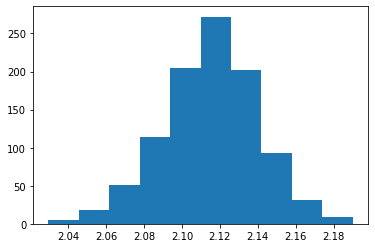

In [21]:
plt.hist(mae)

(array([  8.,  16.,  85., 166., 294., 243., 128.,  54.,   5.,   1.]),
 array([3.09106274, 3.12539066, 3.15971858, 3.19404651, 3.22837443,
        3.26270235, 3.29703028, 3.3313582 , 3.36568612, 3.40001404,
        3.43434197]),
 <a list of 10 Patch objects>)

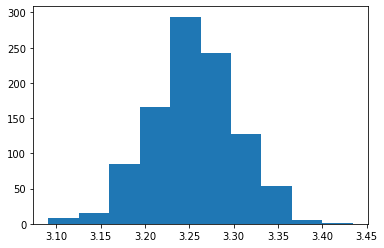

In [22]:
plt.hist(rmse)

In [24]:
print((3/30)*100)

10.0


2014-01-09 00:05:00
2015-12-08 23:48:00
Total trips ended checks out?  True
Total trips started checks out?  True


,Trips Ended,Trips Started,Net Rate
Hour,,,
2014-01-09 00:00:00,3,3,0
2014-01-09 01:00:00,0,0,0
2014-01-09 02:00:00,0,0,0
2014-01-09 03:00:00,0,1,-1
2014-01-09 04:00:00,1,2,-1
...,...,...,...
2015-12-08 19:00:00,84,72,12
2015-12-08 20:00:00,43,37,6
2015-12-08 21:00:00,21,21,0


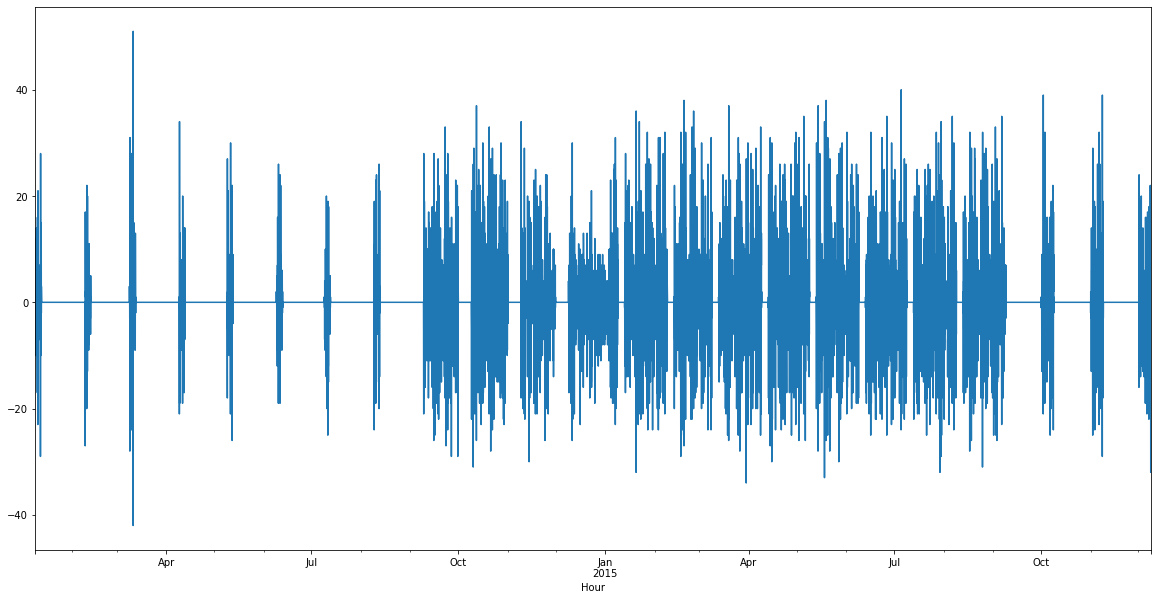

In [48]:
#
# DEPRECATED
#

# THIS DOESN'T COUNT PER STATION THOUGH

dates = [min(trip_data['Start Date']), max(trip_data['Start Date']), min(trip_data['End Date']), max(trip_data['End Date'])]
print(min(dates))
print(max(dates))

# Create range of hour intervals
rng = pd.date_range(start=min(dates), end=max(dates), freq='H', normalize=True)

# Nr of trips ended in hour interval

new_index = trip_data.set_index('End Date', drop=False).index
end_counts = pd.DataFrame(0, index=new_index, columns=['Trips Ended'])
end_counts = end_counts.resample('H').count()
#display(end_counts)
print('Total trips ended checks out? ', end_counts['Trips Ended'].sum() == len(trip_data))

# Nr of trips started in hour interval
new_index = trip_data.set_index('Start Date', drop=False).index
start_counts = pd.DataFrame(0, index=new_index, columns=['Trips Started'])
start_counts = start_counts.resample('H').count()
#display(start_counts)
print('Total trips started checks out? ', start_counts['Trips Started'].sum() == len(trip_data))

# Net rate = ended - started
trip_counts_df = end_counts.merge(start_counts, left_index=True, right_index=True)
trip_counts_df.index.name = 'Hour'
trip_counts_df['Net Rate'] = trip_counts_df['Trips Ended'] - trip_counts_df['Trips Started']
display(trip_counts_df)

trip_counts_df['Net Rate'].plot(figsize=(20,10))

# Step 3: Data exploration

Some plots comparing possibly useful features

Enough data points for neural net?

# Step 4: Data input to models

Extract and combine features

Normalise

# Step 4: Models

# Step 5: Performance